# Multivariate regression on mtcars dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import winsound

from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt
from scipy import stats

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest

In [2]:
class Analyzer():
    def get_error_metrics(self, target, prediction):
        mae = np.mean(np.absolute(prediction - target))
        r2 = r2_score(target, prediction)
        mape = np.dot(np.mean(np.absolute((target - prediction)/target)),100)
        return mae, r2, mape  

## Load data from csv

In [3]:
df = pd.read_csv("mtcars.csv")
df.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


## Feature selection
- Highly correlated score between independent components will be chosen one
    - disp, hp and cyl are highly correlated to one another. Since disp has the lowest correlation to the target (mpg) then disp will be removed
- Features that has low correlation (|x|< 70) to the dependent variable will be removed
    - Exception for carb, this is because feature importance shows it has high correlation to the dependent variable. 

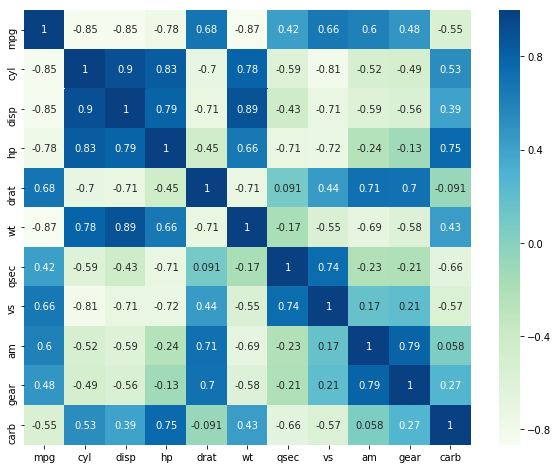

In [4]:
correlation = df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlation, annot=True, cmap='GnBu')

- Find the most significant features with respect to the target

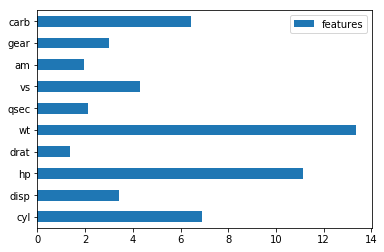

In [5]:
data = df.loc[:,['cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am', 'gear', 'carb']]
target = df['mpg']

best_features = SelectKBest(k='all')
fit = best_features.fit(data, target)
df_score = pd.DataFrame(data=fit.scores_, columns = ['features'], index = data.columns)
df_score.plot(kind='barh')

- Renew feature set with the significant features (cyl, hp, wt, carb)

In [6]:
data = df.loc[:,['cyl', 'hp', 'wt', 'carb']]

## Build Model
- Create matrics to evaluate error
- Create metrics to compare prediction result and target

In [7]:
df_metrics = pd.DataFrame(data=[], index=['MAE', 'R2', 'MAPE'])
df_predictions = pd.DataFrame(data=[])
df_predictions['Target'] = target

cv = 10 

- Find the best hyperparameter using GridSearchCV

In [8]:
l1_ratio = list(np.arange(0.01, 0.99, 0.05))  
alpha = list(np.arange(0.01, 1, 0.05))             
parameters = {'alpha':alpha, 'l1_ratio':l1_ratio}
lr = GridSearchCV(ElasticNet(), parameters, cv=cv)
lr.fit(data, target)
print(lr.best_params_)
winsound.Beep(440, 1000)

C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.11, 'l1_ratio': 0.01}


- Use linear model using ElasticNet as the regularization
- Train with 10 fold validation
- Evaluate error using Mean Average Error (MAE), R2 and Mean Average Percentage Error (MAPE)

#### *Since it is not allowed to split data into training and test set, I interpreted the instruction into 2 possibilities:*
1. Using cross validation since every training set will eventually become test set 
<img src='cv.png' style="width:270px;height:200px">
2. Using exactly training set as the test set. This scheme however, will only generate the most optimistic evaluation score, and has a high risk of overfitting.

In [9]:
## Cross validation
df_predictions['Cross Validation'] = cross_val_predict(
    ElasticNet(alpha = lr.best_params_['alpha'] , l1_ratio = lr.best_params_['l1_ratio']), data, target, cv=cv) 
df_metrics['Cross Validation'] = list(Analyzer().get_error_metrics(target, df_predictions['Cross Validation']))

## Training set as test set
df_predictions['Training as test'] = lr.predict(data)
df_metrics['Training as test'] = list(Analyzer().get_error_metrics(target, df_predictions['Training as test']))

In [10]:
df_metrics

,Cross Validation,Training as test
MAE,2.175082,1.831643
R2,0.753032,0.840843
MAPE,10.586963,9.181728


## Visualize predictions

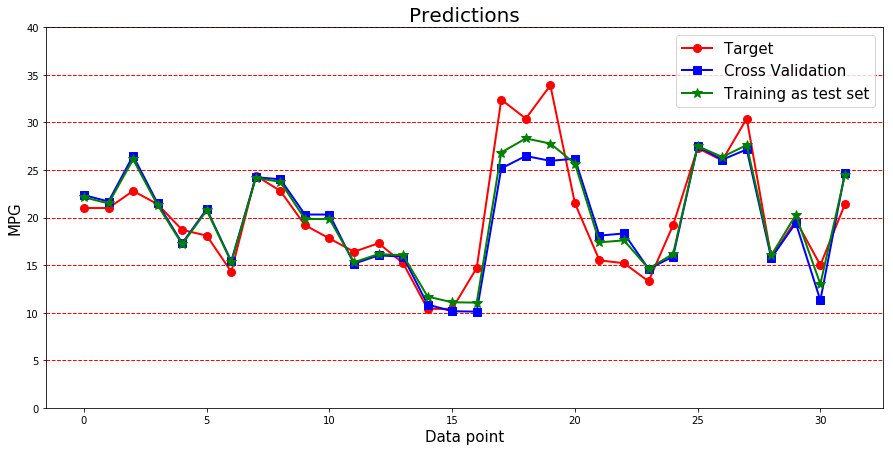

In [11]:
legend = ['Target', 'Cross Validation', 'Training as test set']

fig1, ax = plt.subplots(figsize=(15,7))
ax.plot(df_predictions[ 'Target'], '-o', linewidth=2, markersize=8, color='r')
ax.plot(df_predictions[ 'Cross Validation'], 's-', linewidth=2, markersize=8, color='b')
ax.plot(df_predictions[ 'Training as test'], '*-', linewidth=2, markersize=10, color='g')
ax.legend(legend, fontsize=15)
ax.set_ylim([0, 40])
ax.grid(True, which='major', axis='y',color='r', linestyle='--', linewidth=1)
ax.set_title('Predictions', fontsize=20)
ax.set_ylabel('MPG', fontsize=15)
ax.set_xlabel('Data point', fontsize=15)
fig1.savefig('prediction.png')

## Conclusions
- The model have successfully predict the miles per gallon (mpg) with average error 10.58%.
- Number of cylinders, gross horsepower, weight and number carburators have high impacts to the fuel.
- Rear axle ratio, 1/4 mile time, transmission have low correlations to the fuel.